# MBTI Project - Modeling (step 5)
<br>

<div class="span5 alert alert-info">
<h3>Introduction</h3>
    <p>This notebook contains the <b>Modeling</b> step which comes after the <b>Feature Engineering & Preprocessing</b> step. The main goal of this step involves selecting, training and deploying a model to make predictive insights.<p>
    <p>There are 5 previous notebooks where I did some test-runs on several models to see what algorithms worked best for every pair of MBTI traits. Here we will analyze the results and maybe do some fine-tunning to see if I can improve any of them.</p>
</div>

<a id=top><a>

### Table of Contents

- [Summarized goals](#goals)
- [Importing Libraries](#importing)
- [Review of our Results](#review)
- [Stopwords](#stopwords)
- [Models](#models) 
    - [Extraversion & Introversion Models](#ei) 
    - [Sensing & Intuition Models](#sn) 
    - [Thinking & Feeling Models](#tf) 
    - [Judging & Perceiving Models](#jp) 
- [Final Results](#final)

<a id=goals></a>

## Summarized Goals
***

Find the best model that classifies each post into the pair of attributes of the MBTI:
 - Introversion vs. Extraversion (I vs. E)
 - Intuition vs. Sensing (N vs. S)
 - Thinking vs. Feeling (T vs. F)
 - Judging vs. Perceiving (J vs. P)

<a id=importing></a>

## Imports
***

In [1]:
# data wrangiling libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning libraries
import sklearn
from sklearn.feature_extraction import text
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, matthews_corrcoef, balanced_accuracy_score #classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# other libraries
import os
import re
import random
import string
import pickle
import itertools
import time
import warnings
from tqdm import tqdm, tqdm_pandas

# settings
%matplotlib inline
sns.set() #
tqdm.pandas(desc="Progress!")
pd.options.mode.chained_assignment = None  # default='warn'

/Users/diego/.pyenv/versions/venv-MBTI/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
#we import our original dataset and the results of the models we created in the other notebooks
df = pd.read_csv('../../data/mbti_nlp.csv', index_col=0)
EI = pd.read_csv('model_selection_results_EI.csv', delimiter=';')
NS = pd.read_csv('model_selection_results_NS.csv', delimiter=';')
TF = pd.read_csv('model_selection_results_TF.csv', delimiter=';')
JP = pd.read_csv('model_selection_results_JP.csv', delimiter=';')

<a id=review></a>

<br>

## Reviewing our Results
***

A summary of the different **models** I have tried follows:
- **Models tried:** Naive-Bayes Classifier (NB), Logistic Regression (LR), Support Vector Machines (SVM),k-Nearest Neighbours (kNN), Stocastic Gradient Descent (SGD), Gradient Boosting (GB), XGBoost (XGB), Random Forest (RF)
- **Pending models:** Some models to be tried include Catboost, Adaboost, LightGBM, and deep learning models and transformers.

For every model we used as **input 4 different datasets** according to how words were transformed into vectors:
- CountVectorizer Word Level
- TF-IDF Word Level
- TF-IDF N-Grams Level (2 and 3 words)
- TF-IDF Character Level

The **metrics** we have gathered for each algorithm are:
- accuracy_score
- balanced_accuracy_score
- precision_score
- recall_score
- f1_score
- True Positives (tp)
- True Negatives (tn)
- False Positives (fp)
- False Negatives (fn)
- cohen_kappa_score
- matthews_corrcoef
- roc_auc_score

Before we choose our models we are going revise how balanced our dataset are:

In [3]:
for i,j in zip(['I','N','T','J'],['E','S','F','P']):
    counts = df[i].value_counts()
    print(i, counts[1], j, counts[0])

I 6676 E 1999
N 7478 S 1197
T 3981 F 4694
J 3434 P 5241


We can see how IE and NS are more imbalanced than TF and JP. Accuracy is sensitive to class imbalance and precision, recall, and F1-score are asymmetric. This [article](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a) by Boaz Schmueli says: _"For binary classification, there is another (and arguably more elegant) solution: treat the true class and the predicted class as two (binary) variables, and compute their correlation coefficient (in a similar way to computing correlation coefficient between any two variables). The higher the correlation between true and predicted values, the better the prediction. This is the phi-coefficient (φ), rechristened Matthews Correlation Coefficient (MCC) when applied to classifiers. MCC takes into account all four values in the confusion matrix, and a high value (close to 1) means that both classes are predicted well, even if one class is disproportionately under- (or over-) represented."_  So MCC is a contingency matrix method of calculating the Pearson product-moment correlation coefficient. 

`If r =
   +.70 or higher Very strong positive relationship
   +.40 to +.69 Strong positive relationship
   +.30 to +.39 Moderate positive relationship
   +.20 to +.29 weak positive relationship
   +.01 to +.19 No or negligible relationship
   -.01 to -.19 No or negligible relationship
   -.20 to -.29 weak negative relationship
   -.30 to -.39 Moderate negative relationship
   -.40 to -.69 Strong negative relationship
   -.70 or higher Very strong negative relationsh`

We will evaluate models by their accuracy, MCC and ROC score. I add accuracy because I have seen other people analyzing this dataset and have used accuracy so it will be useful for me to compare results. 

To evaluate the ROC AUC score the following paper [Lemeshow Applied Logistic Regression](https://www.scopus.com/record/display.uri?eid=2-s2.0-0038553009&origin=inward&txGid=523042386e2257cd068e506a14f89c5f) by DW Hosmer, S says:

`In general, an AUC of:
    - 0.5 suggests no discrimination
    - 0.7 to 0.8 is considered acceptable, 
    - 0.8 to 0.9 is considered excellent, and 
    - more than 0.9 is considered outstanding.`

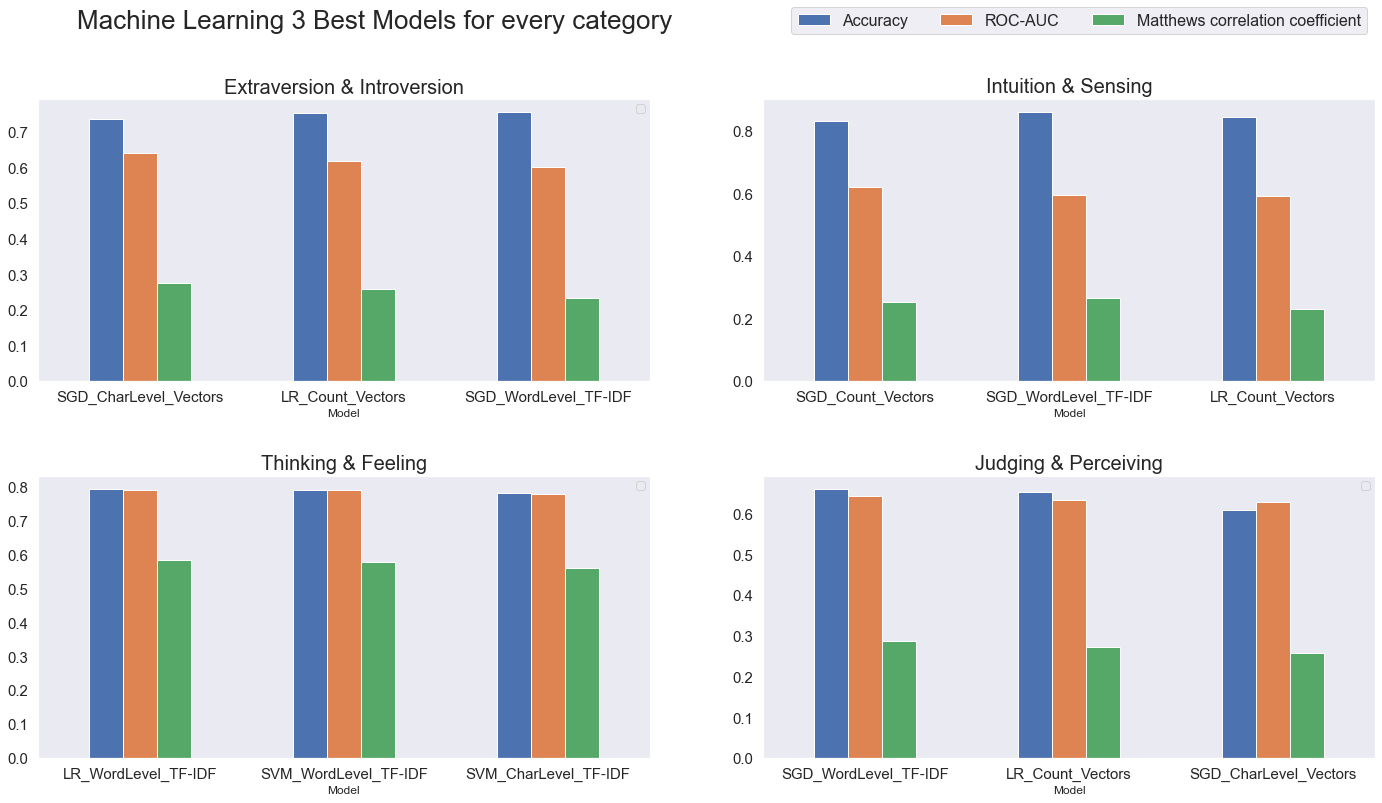

In [4]:
results_ei = EI[['Model', 'acc_overall', 'roc_auc_overall', 'matthews_corrcoef_overall']].sort_values(by='roc_auc_overall', ascending=False).head(3)
results_ns = NS[['Model', 'acc_overall', 'roc_auc_overall', 'matthews_corrcoef_overall']].sort_values(by='roc_auc_overall', ascending=False).head(3)
results_tf = TF[['Model', 'acc_overall', 'roc_auc_overall', 'matthews_corrcoef_overall']].sort_values(by='roc_auc_overall', ascending=False).head(3)
results_jp = JP[['Model', 'acc_overall', 'roc_auc_overall', 'matthews_corrcoef_overall']].sort_values(by='roc_auc_overall', ascending=False).head(3)


plt.rcParams['axes.grid'] = False

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
results_ei.plot(kind='bar', x='Model', rot=0, title='Extraversion & Introversion', fontsize=15, ax = axes[0,0])
results_ns.plot(kind='bar', x='Model', rot=0, title='Intuition & Sensing', fontsize=15, ax = axes[0,1])
results_tf.plot(kind='bar', x='Model', rot=0, title='Thinking & Feeling', fontsize=15, ax = axes[1,0])
results_jp.plot(kind='bar', x='Model', rot=0, title='Judging & Perceiving', fontsize=15, ax = axes[1,1])

plt.figtext(.28,.93,'Machine Learning 3 Best Models for every category',fontsize=26,ha='center')
[x.title.set_size(20) for x in axes.ravel()]

labels = ['Accuracy','ROC-AUC','Matthews correlation coefficient']
axes[0,0].legend('')
axes[0,1].legend(labels=labels, loc=4, ncol=3,  mode="", borderaxespad=.5, frameon=True, bbox_to_anchor=(0, 1.2, 1., .102), fontsize=16)
axes[1,0].legend('')
axes[1,1].legend('')
fig.tight_layout(pad=3.0)

plt.savefig('img/Best_models_by_category.png', transparent=True, bbox_inches='tight')
plt.show()

<a id='stopwords'></a>

<a id='expand'></a>

## Removing Stopwords
***

In [5]:
# we will do add a remove stop words function
def remove_stop_words( x, stop_word):
        '''
        Function to remove a list of words
        @param x : (str) text 
        @param stop_word: (list) list of stopwords to delete 
        @return: (str) new string without stopwords 
        '''
        x_new = text_to_word_sequence(x)    # tokenize text 
        x_ = []
        for i in x_new:
            if i not in stop_word:
                x_.append(i)
        return " ".join(x_)

In [6]:
# MBTI types are rarely discussed in day to day converstaions, we will take them out since they would have low prediction power
types = [x.lower() for x in df['type'].unique()] 
types_plural = [x+'s' for x in types]

# some words that appear a lot but do not add value
additional_stop_words = ['ll','type','fe','ni','na','wa','ve','don','nt','nf', 'ti','se','op','ne']

# We put these together and include the normal stopwords from the English language
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words + types + types_plural)

In [7]:
df['text_clean_joined'] = df['text_clean_joined'].progress_apply(lambda x : remove_stop_words(x, stop_words))

Progress!: 100%|██████████| 8675/8675 [00:02<00:00, 3050.97it/s]


<a id=models></a>

<a id='ei'></a>

## Extraversion & Introversion
***

### Original Models

First let's check if we can replicate our best results and move from there

In [8]:
results_ei

,Model,acc_overall,roc_auc_overall,matthews_corrcoef_overall
27,SGD_CharLevel_Vectors,0.736745,0.641227,0.275968
8,LR_Count_Vectors,0.754265,0.619691,0.259214
25,SGD_WordLevel_TF-IDF,0.756109,0.601278,0.233809


#### Stochastic Gradient Descent

In [21]:
target = 'I'
text = 'text_clean_joined'

In [22]:
#we do the training test split at the same random state as the model was first conceived
X_train, X_test, y_train, y_test = train_test_split(df[text], df[target], test_size=0.25, random_state=42, stratify=df[target])

First let's check if we can replicate our best results and move forward from there

In [23]:
#load the vectorizer and the model from model folder
loaded_vect = pickle.load(open('models/model_selection_results_EI/TF_IDF_ngram_chars_model.sav', 'rb'))
loaded_model = pickle.load(open('models/model_selection_results_EI/SGD_CharLevel_Vectors.sav', 'rb'))

In [24]:
x_train_tfidf_ngram_chars =  loaded_vect.transform(X_train) 
x_test_tfidf_ngram_chars = loaded_vect.transform(X_test)
y_pred = loaded_model.predict(x_test_tfidf_ngram_chars)

In [25]:
print('Accuracy: ', accuracy_score(y_test,y_pred))
print('ROC AUC: ', roc_auc_score(y_test,y_pred))
print('Matthews Correlation Coefficient: ', matthews_corrcoef(y_test,y_pred))

0.7367450437989858
0.641227082085081
0.2759676880500886


The parameters for that concrete model were:
 - loss='modified_huber'
 - max_iter=1000
 - tol=1e-3
 - n_iter_no_change=10
 - early_stopping=True
 - n_jobs=-1
 

### GridSearch to Improve Models

In [57]:
clf = SGDClassifier(loss='modified_huber', max_iter=1000, early_stopping=True, n_jobs=-1)

# use a full grid over all parameters
param_grid = {"n_iter_no_change": np.logspace(0, 2, num=5),
              "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "penalty": ["none", "l1", "l2"],
             'tol':[1e-3,1e-5]}
 
# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring=make_scorer(roc_auc_score, average = 'weighted', multi_class="ovo",needs_proba=True))
start = time.time()
grid_search.fit(x_train_tfidf_ngram_chars, y_train)

y_pred = grid_search.predict(x_test_tfidf_ngram_chars)
print(grid_search.best_params_)

Accuracy:  0.7713231904103274
ROC AUC:  0.5537297783103655
Matthews Correlation Coefficient:  0.18062748939738335

Best Parameters
{'alpha': 0.0001, 'n_iter_no_change': 31.622776601683793, 'penalty': 'l2', 'tol': 1e-05}


In [59]:
clf = SGDClassifier(loss='modified_huber', 
              max_iter=1000, 
              early_stopping=True, 
              n_jobs=-1,
              alpha = 0.0001, 
              n_iter_no_change = 31.622776601683793,
              penalty = 'l2', 
              tol = 1e-05)
clf.fit(x_train_tfidf_ngram_chars, y_train)
y_pred = clf.predict(x_test_tfidf_ngram_chars)
print('Accuracy: ', accuracy_score(y_test,y_pred))
print('ROC AUC: ', roc_auc_score(y_test,y_pred))
print('Matthews Correlation Coefficient: ', matthews_corrcoef(y_test,y_pred))
print()

Accuracy:  0.7570308898109728
ROC AUC:  0.6502061114439783
Matthews Correlation Coefficient:  0.3050139203776766



**Conclusion:** We can see a slight improvement in the three metrics

In [63]:
filename = 'models/final/SGD_TFIDF_Char_Level_EI.sav'
pickle.dump(clf, open(filename, 'wb'))

<a id="sn"></a>

## Sensing & Intuition
***

### Original Models

First let's check if we can replicate our best results and move from there

In [84]:
results_ns

,Model,acc_overall,roc_auc_overall,matthews_corrcoef_overall
20,SGD_Count_Vectors,0.830798,0.619495,0.251991
21,SGD_WordLevel_TF-IDF,0.859843,0.595599,0.265613
4,LR_Count_Vectors,0.845551,0.592929,0.231102


#### Stochastic Gradient Descent

In [85]:
#load the vectorizer and the model from model folder
loaded_vect = pickle.load(open('models/model_selection_results_NS/count_vect_model.sav', 'rb'))
loaded_model = pickle.load(open('models/model_selection_results_NS/SGD_Count_Vectors.sav', 'rb'))

In [86]:
target = 'N'
text = 'text_clean_joined'

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df[text], df[target], test_size=0.25, random_state=42, stratify=df[target])

First let's check if we can replicate our best results and move from there

In [88]:
x_train_count_vect =  loaded_vect.transform(X_train) 
x_test_count_vect = loaded_vect.transform(X_test)
y_pred = loaded_model.predict(x_test_count_vect)

In [89]:
print('Accuracy: ', accuracy_score(y_test,y_pred))
print('ROC AUC: ', roc_auc_score(y_test,y_pred))
print('Matthews Correlation Coefficient: ', matthews_corrcoef(y_test,y_pred))

Accuracy:  0.830797602581835
ROC AUC:  0.6194945719242395
Matthews Correlation Coefficient:  0.2519910507383639


### GridSearch to Improve Models

In [105]:
clf = SGDClassifier(loss='modified_huber', max_iter=1000, early_stopping=True, n_jobs=-1)

# use a full grid over all parameters
param_grid = {"n_iter_no_change": np.logspace(0, 2, num=5),
              "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "penalty": ["none", "l1", "l2"],
             'tol':[1e-3,1e-5]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring=make_scorer(roc_auc_score, average = 'weighted', multi_class="ovo",needs_proba=True))
start = time.time()
grid_search.fit(x_train_count_vect, y_train)

y_pred = grid_search.predict(x_test_count_vect)
print('Best Parameters')
print(grid_search.best_params_)

Best Parameters
{'alpha': 0.1, 'n_iter_no_change': 100.0, 'penalty': 'l2', 'tol': 1e-05}


In [135]:
clf = SGDClassifier(loss='modified_huber', 
              max_iter=1000, 
              early_stopping=True, 
              n_jobs=-1,
              alpha = 0.1, 
              n_iter_no_change = 100,
              penalty = 'l2', 
              tol = 1e-05)
clf.fit(x_train_count_vect, y_train)
y_pred = clf.predict(x_test_count_vect)
print('Accuracy: ', accuracy_score(y_test,y_pred))
print('ROC AUC: ', roc_auc_score(y_test,y_pred))
print('Matthews Correlation Coefficient: ', matthews_corrcoef(y_test,y_pred))
print()

Accuracy:  0.8653757491931766
ROC AUC:  0.5819487417952891
Matthews Correlation Coefficient:  0.26091104472244697



**Conclusion:** This model seems to improve MCC and accuracy but the ROC AUC score is lower than our previous model for some reason I was not able to detect.

In [136]:
#We save the model
filename = 'models/final/SGD_Count_Vect_NS.sav'
pickle.dump(clf, open(filename, 'wb'))

<a id="tf"></a>

## Thinking & Feeling
***

### Original Models

First let's check if we can replicate our best results and move from there

In [137]:
results_tf

,Model,acc_overall,roc_auc_overall,matthews_corrcoef_overall
5,LR_WordLevel_TF-IDF,0.792992,0.792224,0.583760
9,SVM_WordLevel_TF-IDF,0.789765,0.789626,0.578033
11,SVM_CharLevel_TF-IDF,0.781466,0.780044,0.560003


#### Logistic Regression

In [138]:
#load the vectorizer and the model from model folder
loaded_vect = pickle.load(open('models/model_selection_results_TF/TF_IDF_model.sav', 'rb'))
loaded_model = pickle.load(open('models/model_selection_results_TF/LR_WordLevel_TF-IDF.sav', 'rb'))

In [139]:
target = 'T'
text = 'text_clean_joined'

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df[text], df[target], test_size=0.25, random_state=42, stratify=df[target])

First let's check if we can replicate our best results and move from there

In [141]:
x_train_tfidf_word =  loaded_vect.transform(X_train) 
x_test_tfidf_word = loaded_vect.transform(X_test)
y_pred = loaded_model.predict(x_test_tfidf_word)

In [142]:
print('Accuracy: ', accuracy_score(y_test,y_pred))
print('ROC AUC: ', roc_auc_score(y_test,y_pred))
print('Matthews Correlation Coefficient: ', matthews_corrcoef(y_test,y_pred))

Accuracy:  0.792992162286768
ROC AUC:  0.7922238963129105
Matthews Correlation Coefficient:  0.5837600572096417


### GridSearch to Improve Models

In [145]:
clf.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [153]:
# Create classifer
clf = LogisticRegression()

# Create param grid.
param_grid = [
    {'penalty' : ['none','l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear'],
    'max_iter' : [1,10,100,1000]}]

# Create grid search object
clf = GridSearchCV(clf, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(x_train_tfidf_word, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 686 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1036 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  2.7min finished


In [154]:
best_clf.best_params_

{'C': 1.623776739188721,
 'max_iter': 10,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [155]:
clf = LogisticRegression(C = 1.623776739188721, max_iter = 10, penalty = 'l2', solver = 'liblinear')

clf.fit(x_train_tfidf_word, y_train)
y_pred = clf.predict(x_test_tfidf_word)
print('Accuracy: ', accuracy_score(y_test,y_pred))
print('ROC AUC: ', roc_auc_score(y_test,y_pred))
print('Matthews Correlation Coefficient: ', matthews_corrcoef(y_test,y_pred))
print()

Accuracy:  0.792992162286768
ROC AUC:  0.7926069872360096
Matthews Correlation Coefficient:  0.5841886570237305



**Conclusion:** Slight improvement from the previous

In [156]:
filename = 'models/final/LR_TFIDF_Word_Level_TF.sav'
pickle.dump(clf, open(filename, 'wb'))

<a id="jp"></a>

## Judging & Perceiving
***

### Original Models

First let's check if we can replicate our best results and move from there

In [157]:
results_jp

,Model,acc_overall,roc_auc_overall,matthews_corrcoef_overall
21,SGD_WordLevel_TF-IDF,0.660673,0.643335,0.287878
4,LR_Count_Vectors,0.653757,0.635406,0.272378
23,SGD_CharLevel_Vectors,0.609036,0.630045,0.257238


#### Stochastic Gradient Descent

In [158]:
#load the vectorizer and the model from model folder
loaded_vect = pickle.load(open('models/model_selection_results_JP/TF_IDF_model.sav', 'rb'))
loaded_model = pickle.load(open('models/model_selection_results_JP/SGD_WordLevel_TF-IDF.sav', 'rb'))

In [159]:
target = 'J'
text = 'text_clean_joined'

In [160]:
X_train, X_test, y_train, y_test = train_test_split(df[text], df[target], test_size=0.25, random_state=42, stratify=df[target])

In [161]:
x_train_tfidf_word =  loaded_vect.transform(X_train) 
x_test_tfidf_word = loaded_vect.transform(X_test)
y_pred = loaded_model.predict(x_test_tfidf_word)

In [163]:
print('Accuracy: ', accuracy_score(y_test,y_pred))
print('ROC AUC: ', roc_auc_score(y_test,y_pred))
print('Matthews Correlation Coefficient: ', matthews_corrcoef(y_test,y_pred))

Accuracy:  0.6606731212540341
ROC AUC:  0.6433354957388762
Matthews Correlation Coefficient:  0.28787846434409475


### GridSearch to Improve Models

In [164]:
clf = SGDClassifier(loss='modified_huber', max_iter=1000, early_stopping=True, n_jobs=-1)

# use a full grid over all parameters
param_grid = {"n_iter_no_change": np.logspace(0, 2, num=5),
              "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "penalty": ["none", "l1", "l2"],
             'tol':[1e-3,1e-5]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring=make_scorer(roc_auc_score, average = 'weighted', multi_class="ovo",needs_proba=True))
start = time.time()
grid_search.fit(x_train_tfidf_word, y_train)

y_pred = grid_search.predict(x_test_tfidf_word)
print('Best Parameters')
print(grid_search.best_params_)

Best Parameters
{'alpha': 0.001, 'n_iter_no_change': 31.622776601683793, 'penalty': 'l2', 'tol': 0.001}


In [198]:
clf = SGDClassifier(loss='modified_huber', 
              max_iter=1000, 
              early_stopping=True, 
              n_jobs=-1,
              alpha = 0.001, 
              n_iter_no_change = 31.622776601683793,
              penalty = 'l2', 
              tol = 0.001)
clf.fit(x_train_tfidf_word, y_train)
y_pred = clf.predict(x_test_tfidf_word)
print('Accuracy: ', accuracy_score(y_test,y_pred))
print('ROC AUC: ', roc_auc_score(y_test,y_pred))
print('Matthews Correlation Coefficient: ', matthews_corrcoef(y_test,y_pred))
print()

Accuracy:  0.6657445827570309
ROC AUC:  0.6210821210532396
Matthews Correlation Coefficient:  0.27000087720547894



**Conclusion:** We have not been able to get as good results as we had before. We will keep the original model.

In [136]:
#filename = 'models/final/SGD_TFIDF_Word_Level_JP.sav'
#pickle.dump(clf, open(filename, 'wb'))

<a id=final><a>

## FINAL RESULTS

In [208]:
final_df = pd.DataFrame(columns=['Model','Accuracy','ROC_AUC','MCC'])

In [218]:
# Extraversion and Introversion
loaded_vect = pickle.load(open('models/model_selection_results_EI/TF_IDF_ngram_chars_model.sav', 'rb'))
loaded_model = pickle.load(open('models/final/SGD_TFIDF_Char_Level_EI.sav', 'rb'))
target = 'I'
text = 'text_clean_joined'
X_train, X_test, y_train, y_test = train_test_split(df[text], df[target], test_size=0.25, random_state=42, stratify=df[target])
x_train_tfidf_ngram_chars =  loaded_vect.transform(X_train) 
x_test_tfidf_ngram_chars = loaded_vect.transform(X_test)
y_pred = loaded_model.predict(x_test_tfidf_ngram_chars)

results = {'Model': 'EI_SGD_TFIDF_Char_Level', 
     'Accuracy':accuracy_score(y_test,y_pred),
     'ROC_AUC':roc_auc_score(y_test,y_pred),
     'MCC': matthews_corrcoef(y_test,y_pred)}

final_df = final_df.append(results, ignore_index=True)

In [219]:
# Sensing and Intuition
loaded_vect = pickle.load(open('models/model_selection_results_NS/count_vect_model.sav', 'rb'))
loaded_model = pickle.load(open('models/final/SGD_Count_Vect_NS.sav', 'rb'))
target = 'N'
text = 'text_clean_joined'
X_train, X_test, y_train, y_test = train_test_split(df[text], df[target], test_size=0.25, random_state=42, stratify=df[target])
x_train_count_vect =  loaded_vect.transform(X_train) 
x_test_count_vect = loaded_vect.transform(X_test)
y_pred = loaded_model.predict(x_test_count_vect)

results = {'Model': 'NS_SGD_Count_Vect', 
           'Accuracy':accuracy_score(y_test,y_pred),
           'ROC_AUC':roc_auc_score(y_test,y_pred),
           'MCC': matthews_corrcoef(y_test,y_pred)}

final_df = final_df.append(results, ignore_index=True)

In [220]:
# Thinking and Feeling
loaded_vect = pickle.load(open('models/model_selection_results_TF/TF_IDF_model.sav', 'rb'))
loaded_model = pickle.load(open('models/model_selection_results_TF/LR_WordLevel_TF-IDF.sav', 'rb'))
target = 'T'
text = 'text_clean_joined'
X_train, X_test, y_train, y_test = train_test_split(df[text], df[target], test_size=0.25, random_state=42, stratify=df[target])
x_train_tfidf_word =  loaded_vect.transform(X_train) 
x_test_tfidf_word = loaded_vect.transform(X_test)
y_pred = loaded_model.predict(x_test_tfidf_word)

results = {'Model': 'TF_LR_TFIDF_Word_Level', 
           'Accuracy':accuracy_score(y_test,y_pred),
           'ROC_AUC':roc_auc_score(y_test,y_pred),
           'MCC': matthews_corrcoef(y_test,y_pred)}

final_df = final_df.append(results, ignore_index=True)

In [221]:
# Judging and Perceiving
loaded_vect = pickle.load(open('models/model_selection_results_JP/TF_IDF_model.sav', 'rb'))
loaded_model = pickle.load(open('models/model_selection_results_JP/SGD_WordLevel_TF-IDF.sav', 'rb'))
target = 'J'
text = 'text_clean_joined'
X_train, X_test, y_train, y_test = train_test_split(df[text], df[target], test_size=0.25, random_state=42, stratify=df[target])
x_train_tfidf_word =  loaded_vect.transform(X_train) 
x_test_tfidf_word = loaded_vect.transform(X_test)
y_pred = loaded_model.predict(x_test_tfidf_word)

results = {'Model': 'JP_SGD_TFIDF_Word_Level', 
           'Accuracy':accuracy_score(y_test,y_pred),
           'ROC_AUC':roc_auc_score(y_test,y_pred),
           'MCC': matthews_corrcoef(y_test,y_pred)}

final_df = final_df.append(results, ignore_index=True)

In [222]:
final_df

,Model,Accuracy,ROC_AUC,MCC
0,EI_SGD_TFIDF_Char_Level,0.757031,0.650206,0.305014
1,NS_SGD_Count_Vect,0.865376,0.581949,0.260911
2,TF_LR_TFIDF_Word_Level,0.792992,0.792224,0.583760
3,JP_SGD_TFIDF_Word_Level,0.660673,0.643335,0.287878


In [264]:
rects = axes.patches

In [304]:
# Create an empty list 
Row_list =[] 
  
# Iterate over each row 
for col in final_df.columns[1:]:
    Row_list.extend(final_df[col].to_list())
    
Row_list = [round(x,2) for x in Row_list]

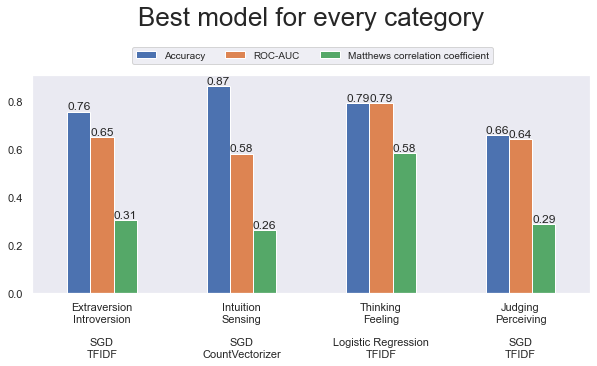

In [314]:

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

final_df.plot(kind='bar', x='Model', ax = axes)

plt.title('Best model for every category',fontsize=26,ha='center', pad=50)
plt.xticks(ticks=[0,1,2,3],labels=['Extraversion\nIntroversion\n\nSGD\nTFIDF',
                                   'Intuition\nSensing\n\nSGD\nCountVectorizer',
                                   'Thinking\nFeeling\n\nLogistic Regression\nTFIDF',
                                   'Judging\nPerceiving\n\nSGD\nTFIDF'], rotation=360)
plt.xlabel('')

rects = axes.patches

for rect, value in zip(rects, Row_list):
    height = rect.get_height()
    axes.text(rect.get_x() + rect.get_width() / 2, height, s=value, ha='center', va='bottom')

labels = ['Accuracy','ROC-AUC','Matthews correlation coefficient']
plt.legend(labels=labels, loc=3, ncol=3,  mode="", borderaxespad=.5, frameon=True, bbox_to_anchor=(0.17, 1.03, 1., 0), fontsize=10)

plt.savefig('img/Final_Models.png', transparent=True, bbox_inches='tight')
plt.show()